In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import tarfile
import torchvision.datasets as datasets
import os
from tqdm import tqdm
import seaborn
import matplotlib.pyplot as plt

In [162]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),  
])


In [163]:
dataset = datasets.ImageFolder(root='dataset', transform=transform)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


class_names = dataset.classes
class_names


['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

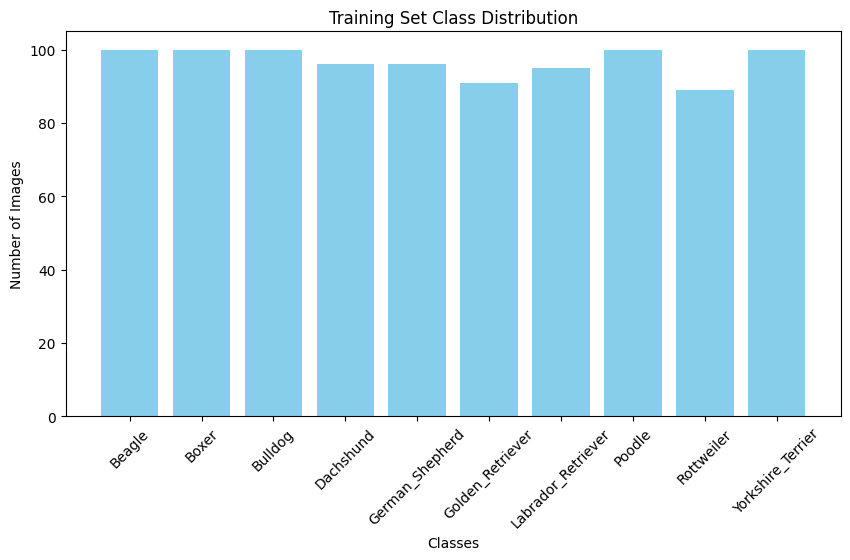

Class counts: {'Beagle': 100, 'Boxer': 100, 'Bulldog': 100, 'Dachshund': 96, 'German_Shepherd': 96, 'Golden_Retriever': 91, 'Labrador_Retriever': 95, 'Poodle': 100, 'Rottweiler': 89, 'Yorkshire_Terrier': 100}


In [164]:
import os 

def count_images_per_class(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_class_counts = count_images_per_class('dataset')

def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_class_counts, 'Training Set Class Distribution')
print("Class counts:", train_class_counts)

In [165]:
num_classes = len(dataset.classes)
img, label = dataset[0]
img_shape = img.shape
img_size = img_shape[-1]
(num_classes, img_size)

(10, 32)

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
import random
def show_example():
    int = random.randint(0, len(dataset)-1)
    img, label = dataset[int]
    plt.imshow(img.permute(1,2,0))
    print("Label: " , dataset.classes[label] + " ["+str(label)+"]")

Label:  Bulldog [2]


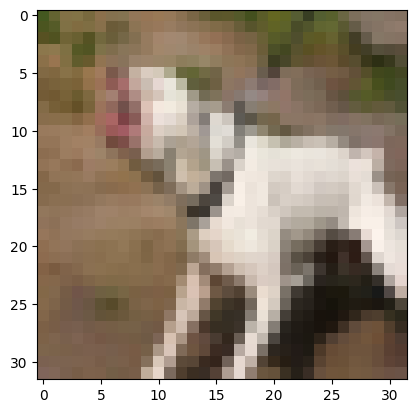

In [168]:
show_example()

In [169]:
batch_size = 128


train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False)

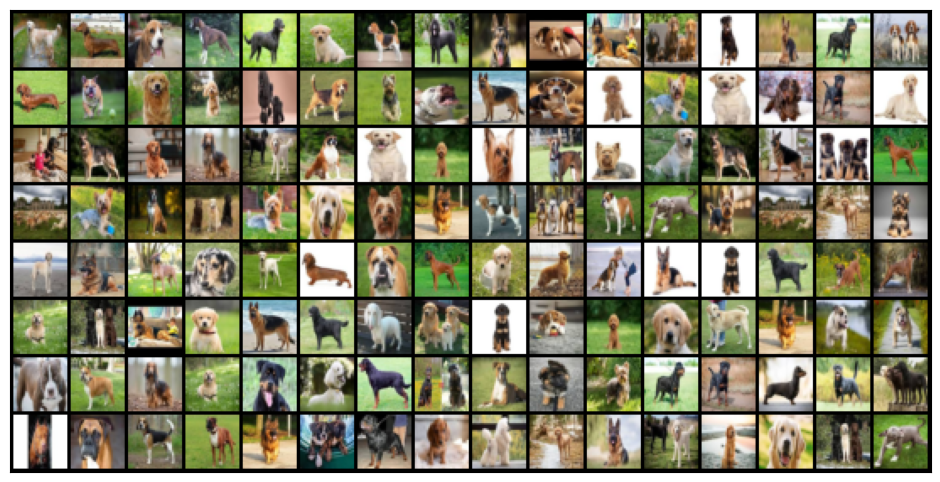

In [170]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)


In [172]:
def conv_block(in_channels,out_channels,stride=1,pool=False):
    layers = [
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.01, inplace=True),
    ]
    if pool:
        layers.append (nn.AvgPool2d(2))
    return nn.Sequential(*layers)

In [173]:
class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Initial convolution
        self.conv1 = conv_block(in_channels, 64, stride=2)  # 64 x 24 x 24
        
        # First stack
        self.conv2 = conv_block(64, 64)  # 64 x 24 x 24
        self.res1 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 64)
        )
        
        # Second stack
        self.conv3 = conv_block(64, 128, stride=2)  # 128 x 12 x 12
        self.res2 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)
        )
        
        # Third stack
        self.conv4 = conv_block(128, 256, stride=2)  # 256 x 6 x 6
        self.res3 = nn.Sequential(
            conv_block(256, 256),
            conv_block(256, 256)
        )
        
        # Fourth stack
        self.conv5 = conv_block(256, 512, stride=2)  # 512 x 3 x 3
        self.res4 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # 512 x 1 x 1
            nn.Flatten(),  # 512
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # 256
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)  # num_classes
        )
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        x = self.res1(x) + x
        
        x = self.conv3(x)
        x = self.res2(x) + x
        
        x = self.conv4(x)
        x = self.res3(x) + x
        
        x = self.conv5(x)
        x = self.res4(x) + x
        
        x = self.classifier(x)
        
        return x

In [174]:
model = ResNet(3,num_classes)

In [175]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

In [176]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [177]:
model.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [178]:
import matplotlib.pyplot as plt

def train(train_loader, model, criterion, optimizer, num_epochs):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        total_loss = 0.0
        train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()

Epoch [1/25], Train Loss: 2.1925, Train Accuracy: 26.39%


Epoch [2/25], Train Loss: 1.7439, Train Accuracy: 74.77%


Epoch [3/25], Train Loss: 1.4687, Train Accuracy: 93.27%


Epoch [4/25], Train Loss: 1.0874, Train Accuracy: 97.80%


Epoch [5/25], Train Loss: 0.7875, Train Accuracy: 98.97%


Epoch [6/25], Train Loss: 0.5100, Train Accuracy: 100.00%


Epoch [7/25], Train Loss: 0.3724, Train Accuracy: 100.00%


Epoch [8/25], Train Loss: 0.2518, Train Accuracy: 100.00%


Epoch [9/25], Train Loss: 0.1690, Train Accuracy: 100.00%


Epoch [10/25], Train Loss: 0.1674, Train Accuracy: 100.00%


Epoch [11/25], Train Loss: 0.1076, Train Accuracy: 100.00%


Epoch [12/25], Train Loss: 0.2562, Train Accuracy: 99.87%


Epoch [13/25], Train Loss: 0.1848, Train Accuracy: 99.87%


Epoch [14/25], Train Loss: 0.1323, Train Accuracy: 99.87%


Epoch [15/25], Train Loss: 0.1143, Train Accuracy: 100.00%


Epoch [16/25], Train Loss: 0.1331, Train Accuracy: 100.00%


Epoch [17/25], Train Loss: 0.1111, Train Accuracy: 100.00%


Epoch [18/25], Train Loss: 0.0954, Train Accuracy: 100.00%


Epoch [19/25], Train Loss: 0.1356, Train Accuracy: 99.74%


Epoch [20/25], Train Loss: 0.1034, Train Accuracy: 100.00%


Epoch [21/25], Train Loss: 0.1084, Train Accuracy: 99.74%


Epoch [22/25], Train Loss: 0.1170, Train Accuracy: 100.00%


Epoch [23/25], Train Loss: 0.1145, Train Accuracy: 99.87%


Epoch [24/25], Train Loss: 0.3418, Train Accuracy: 99.61%


Epoch [25/25], Train Loss: 0.0723, Train Accuracy: 100.00%


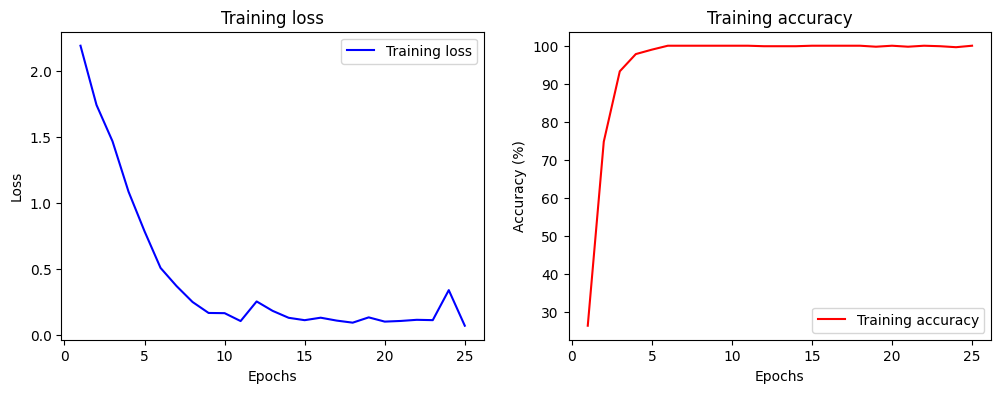

In [179]:
train(train_dl, model, criterion, optimizer, num_epochs=25)


In [180]:
torch.save(model.state_dict(), 'Dog_Classifier.pth')


In [181]:
PATH = 'Dog_Classifier.pth'
state = {'model': model.state_dict()}
torch.save(state, PATH)
model.load_state_dict(torch.load(PATH)['model'])
for k, v in model.named_parameters():
    print(k, v)

conv1.0.weight Parameter containing:
tensor([[[[ 0.1069,  0.1827, -0.1816],
          [ 0.1143,  0.0583,  0.1289],
          [-0.1726, -0.1903,  0.1392]],

         [[-0.0224, -0.0116, -0.1851],
          [ 0.0681,  0.1209,  0.0487],
          [-0.1880, -0.0011, -0.0381]],

         [[-0.0863,  0.0825, -0.1207],
          [ 0.1653, -0.1788,  0.1651],
          [ 0.0582, -0.1870, -0.1077]]],


        [[[-0.1170,  0.1117,  0.0235],
          [ 0.0212,  0.0667,  0.1700],
          [ 0.1327,  0.1277,  0.0504]],

         [[ 0.1310, -0.0421,  0.0071],
          [-0.0457, -0.1214, -0.0167],
          [-0.0504, -0.1677,  0.1404]],

         [[ 0.1314, -0.0339,  0.1873],
          [ 0.1329,  0.0706, -0.1613],
          [-0.0256, -0.0109,  0.1706]]],


        [[[ 0.1818,  0.0846,  0.0327],
          [-0.0954, -0.0339,  0.1428],
          [ 0.1863,  0.0073,  0.1670]],

         [[ 0.0662, -0.1758,  0.1331],
          [ 0.1530, -0.1284,  0.1392],
          [-0.0283,  0.0183, -0.0209]],

       

Accuracy: 1.00


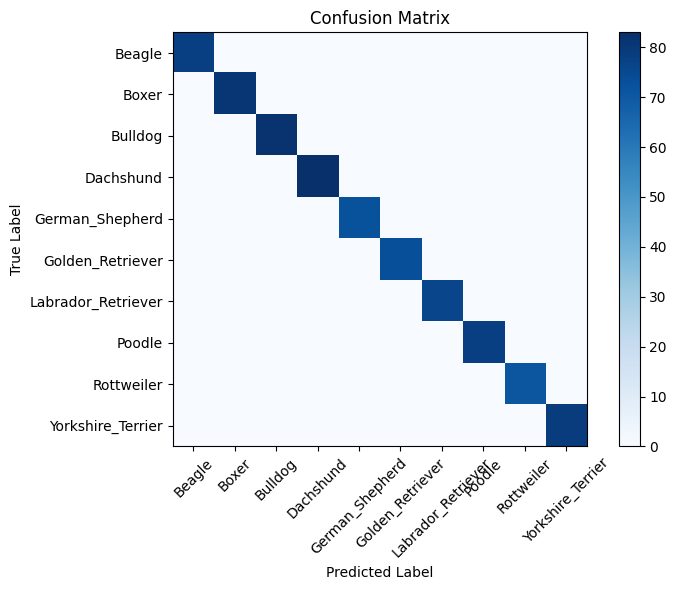

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        78
             Boxer       1.00      1.00      1.00        81
           Bulldog       1.00      1.00      1.00        82
         Dachshund       1.00      1.00      1.00        83
   German_Shepherd       1.00      1.00      1.00        72
  Golden_Retriever       1.00      1.00      1.00        73
Labrador_Retriever       1.00      1.00      1.00        76
            Poodle       1.00      1.00      1.00        78
        Rottweiler       1.00      1.00      1.00        71
 Yorkshire_Terrier       1.00      1.00      1.00        79

          accuracy                           1.00       773
         macro avg       1.00      1.00      1.00       773
      weighted avg       1.00      1.00      1.00       773



In [182]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Accuracy: {accuracy:.2f}')

class_names = dataset.classes
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


Testing Accuracy: 0.99


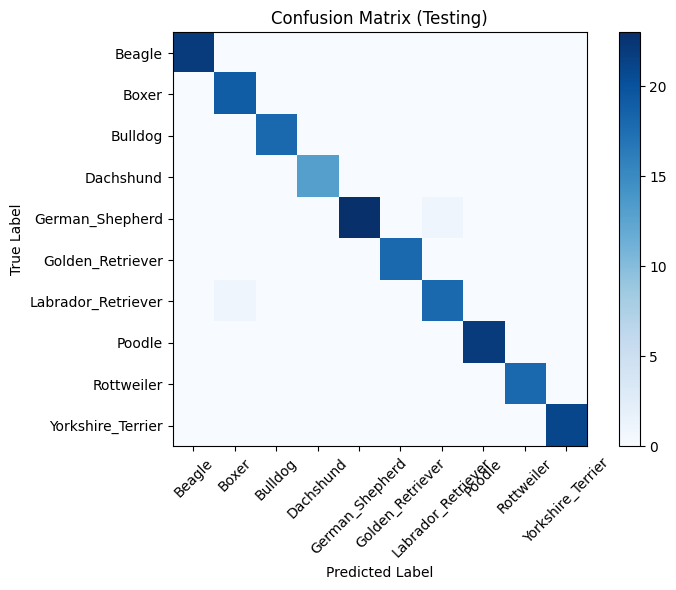

                    precision    recall  f1-score   support

            Beagle       1.00      1.00      1.00        22
             Boxer       0.95      1.00      0.97        19
           Bulldog       1.00      1.00      1.00        18
         Dachshund       1.00      1.00      1.00        13
   German_Shepherd       1.00      0.96      0.98        24
  Golden_Retriever       1.00      1.00      1.00        18
Labrador_Retriever       0.95      0.95      0.95        19
            Poodle       1.00      1.00      1.00        22
        Rottweiler       1.00      1.00      1.00        18
 Yorkshire_Terrier       1.00      1.00      1.00        21

          accuracy                           0.99       194
         macro avg       0.99      0.99      0.99       194
      weighted avg       0.99      0.99      0.99       194



In [183]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
accuracy = np.mean(predictions == true_labels)
print(f'Testing Accuracy: {accuracy:.2f}')

conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Testing)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print(classification_report(true_labels, predictions, target_names=class_names))


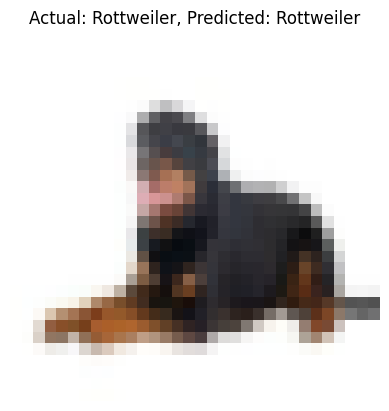

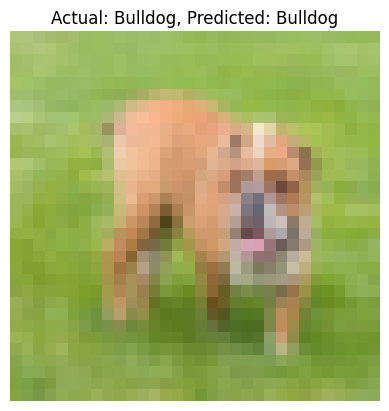

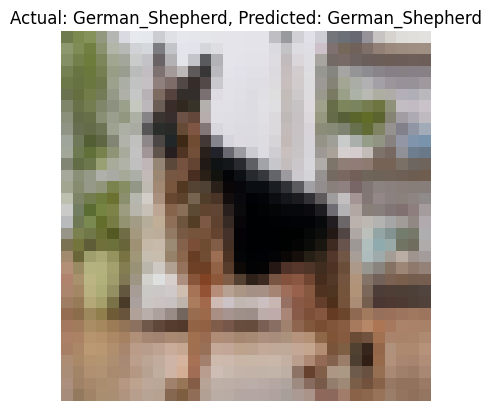

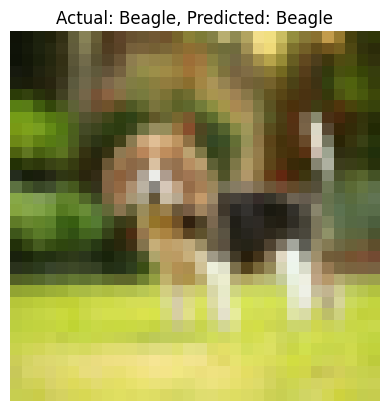

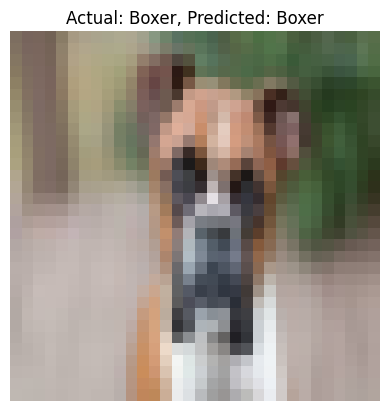

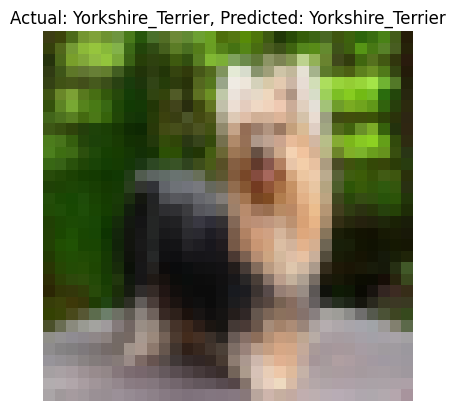

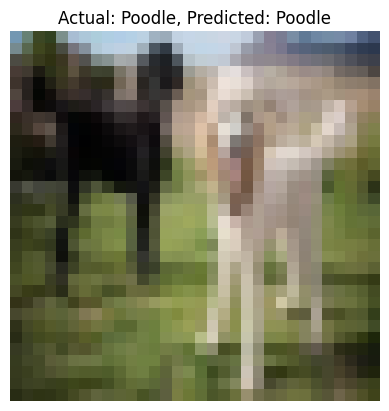

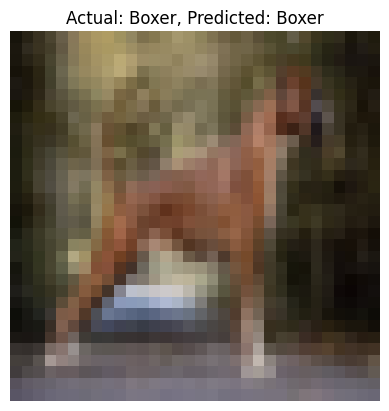

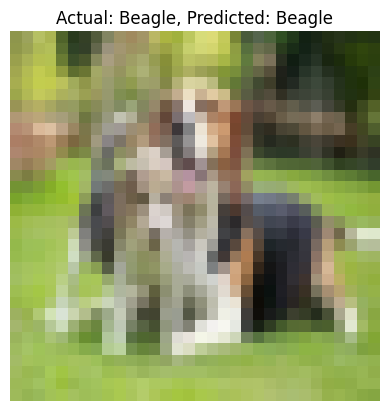

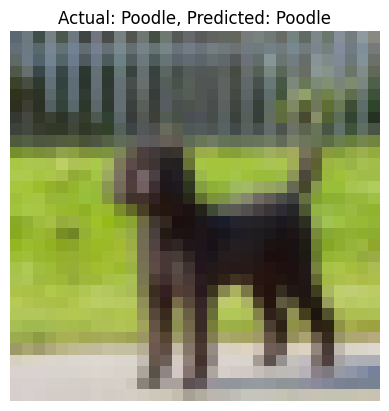

In [184]:
def imshow(img, title):
    npimg = img.cpu().numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

indices = np.random.randint(0, len(test_dataset), size=10)
random_images = [test_dataset[i] for i in indices]

images = torch.stack([img for img, _ in random_images])
labels = [label for _, label in random_images]

images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

predicted = predicted.tolist()
labels = [dataset.classes[label] for label in labels]
predicted_labels = [dataset.classes[label] for label in predicted]

for i in range(10):
    imshow(images[i], f'Actual: {labels[i]}, Predicted: {predicted_labels[i]}')


In [185]:
from PIL import Image
import torch
import torchvision.transforms as transforms

def predict_image_class(image_path, model, class_names):
    image_path = "images/" + image_path
    entered_image = Image.open(image_path)

    
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    transformed_image = transform(entered_image).unsqueeze(0)  

    
    model.eval()

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformed_image = transformed_image.to(device)

    
    with torch.no_grad():
        outputs = model(transformed_image)

    
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()  

    
    probs = torch.softmax(outputs, dim=1)
    predicted_prob = probs[0, predicted_class].item()

    print(f'Predicted Class: {class_names[predicted_class]}, Probability: {predicted_prob:.2f}')
    
    plt.imshow(entered_image)
    plt.show()


Predicted Class: Bulldog, Probability: 0.99


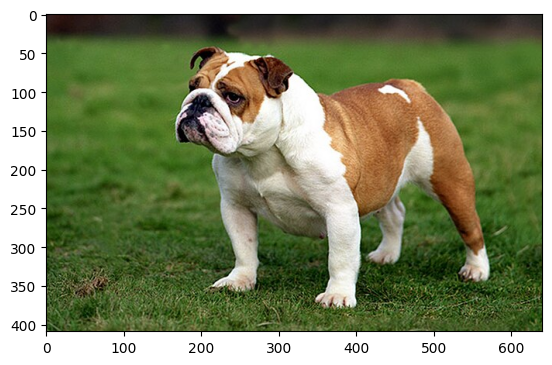

In [192]:
predict_image_class('img1.jpg', model, class_names)

Predicted Class: German_Shepherd, Probability: 0.95


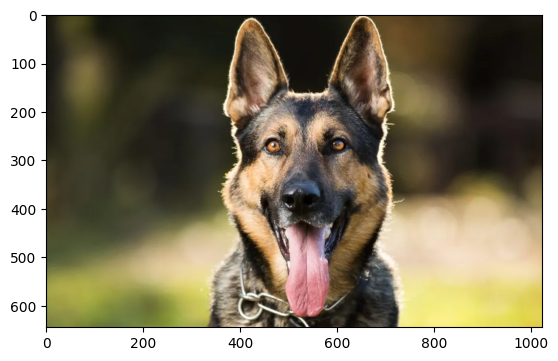

In [187]:
predict_image_class('img2.jpg', model, class_names)

Predicted Class: Dachshund, Probability: 0.98


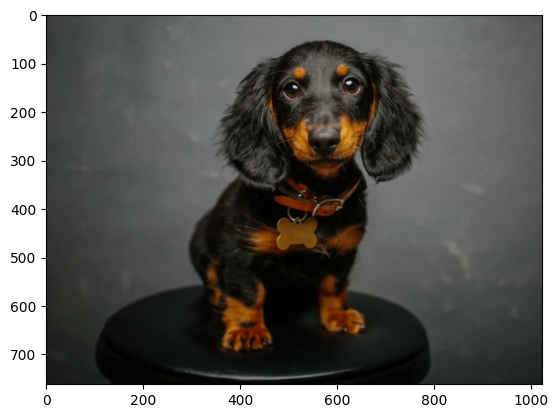

In [188]:
predict_image_class('img3.jpg', model, class_names)

Predicted Class: Golden_Retriever, Probability: 1.00


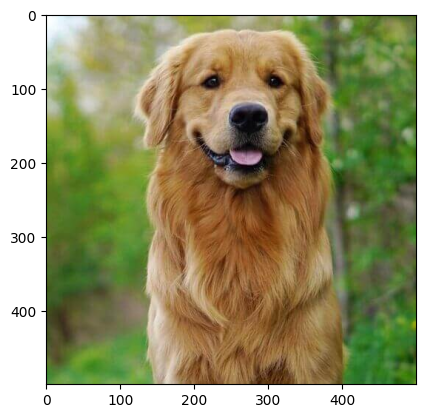

In [195]:
predict_image_class('img4.jpg', model, class_names)